# Using TDEs to build a fault model with topography.

Welcome to the TDE sequence. Here, we'll build tools for doing 3D fault modeling using triangular dislocation elements (TDEs).

In this first section, the goal here is to calculate the surface displacements and stresses due to a known slip field on a fault. The free surface will have real topography and Earth curvature! This is a step up from the half-space with a rectangular fault that's super common in earthquake science. I'll be using a fullspace TDE implementation introduced by {cite:p}`nikkhoo2015triangular` as implemented in my [GPU-accelerated version `cutde`](https://github.com/tbenthompson/cutde). `cutde` works best with a Nvidia GPU, but should also work on almost any modern computer because there is also an OpenCL backend.

**WARNING:** Any constant-slip dislocation method (Okada, TDEs) will result in *stress singularities* at the edges of each elements. This might be disastrous for problems like quasidynamic rupture where we are calculating stress values directly on the fault surface. Because we're calculating displacements instead of stresses, we don't have to worry about this problem here. For any problems that require calculating stresses on the boundary, I would recommend using [a different method](../c1qbx/part1_nearfield).

## Fullspace example

I'll start with an example of how to run some fullspace displacement calculations with `cutde`.

In [1]:
import cutde
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format='retina'

First, let's define the observation point grid. The `pts` array will be `(N, 3)` specifying each observation point in 3D. The grid ranges from `(-2000, -2000, 0)` in the "southwest" corner to `(2000, 2000, 0)` in the "northeast" corner.

In [3]:
nobs = 50
W = 2000
zoomx = [-W, W]
zoomy = [-W, W]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)
pts = np.array([obsx, obsy, 0 * obsy]).reshape((3, -1)).T.copy()

And a rectangular fault consisting of two triangles. Here, I'm splitting the geometry into `(N, 3)` array of points and an `(N, 3)` array of integer indexes that specify which points compose each triangle. Note that this is a vertical fault lying along the x-axis.

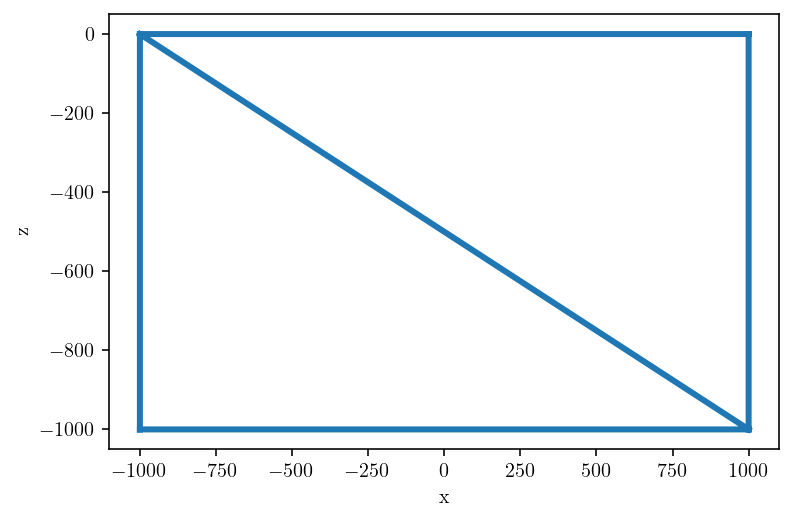

In [4]:
fault_L = 1000.0
fault_H = 1000.0
fault_D = 0.0
fault_pts = np.array(
    [
        [-fault_L, 0, -fault_D],
        [fault_L, 0, -fault_D],
        [fault_L, 0, -fault_D - fault_H],
        [-fault_L, 0, -fault_D - fault_H],
    ]
)
fault_tris = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.int64)
plt.triplot(fault_pts[:, 0], fault_pts[:, 2], fault_tris)
plt.xlabel("x")
plt.ylabel("z")
plt.show()

Here's where we use `cutde`. The `disp_matrix` function takes an `(N_OBS_PTS, 3)` array of observation points, an `(N_SRC_TRIS, 3, 3)` array specifying each vertex of the source triangles and finally `nu` which is Poisson's ratio. The output is an array with shape `(N_OBS_PTS, 3, N_SRC_TRIS, 3)` where the second dimension refers to the components of the displacement vector and the fourth dimensions refers to the components of the slip vector.

In [5]:
disp_mat = cutde.disp_matrix(obs_pts=pts, tris=fault_pts[fault_tris], nu=0.25)

We want to consider a unit strike-slip motion, so we'll sum the first component of the source side of the matrix to get `disp`. Then, reshape to a grid:

In [6]:
disp = np.sum(disp_mat[:, :, :, 0], axis=2)
disp = disp.reshape((obsx.shape[0], obsx.shape[1], 3))

And finally, let's plot the displacement field! To be very clear, **this is not the Okada half space solution** that we'll replicate in the next section. This is a full space solution.

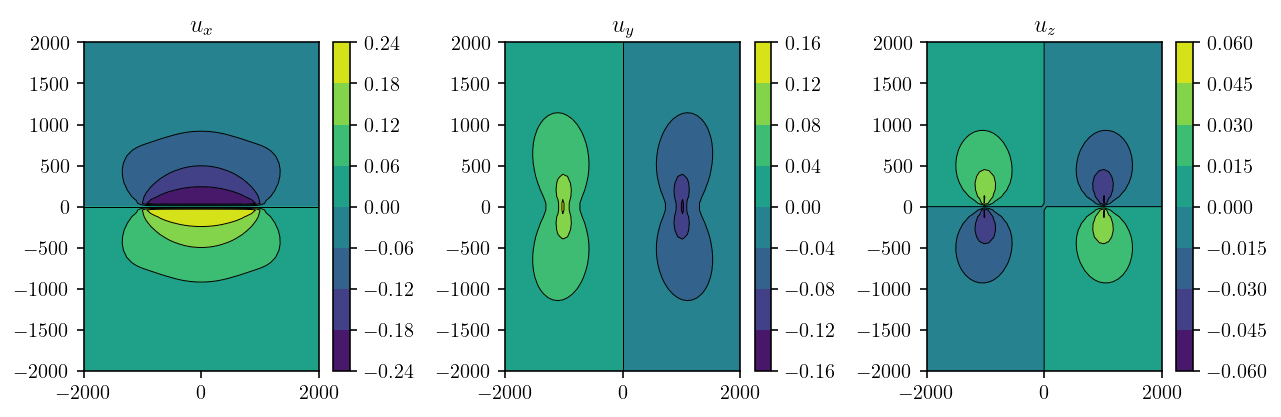

In [7]:
plt.figure(figsize=(9, 3))
for d in range(3):
    plt.subplot(1, 3, 1 + d)
    cntf = plt.contourf(obsx, obsy, disp[:, :, d])
    plt.contour(obsx, obsy, disp[:, :, d], colors="k", linestyles="-", linewidths=0.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f"$u_{['x','y','z'][d]}$")
plt.tight_layout()
plt.show()

## Halfspace example

Okay, fullspace was cool. I guess? But, the point here is to do something with a free surface and topography! We will compare against the rectangular dislocation solutions developed by {cite:t}`Okada1992`.

So, let's start by replicating the Okada solution using fullspace TDEs. To explain how to do that, I'll back up and explain some elastic integral equation background. It's not absolutely critical to understand the details here, but it does really help to explain what's going on. I generally regret it when I skip the mathematical background to a method!

### The Somigliana identity

The underlying basis of almost any (static, isotropic, homogeneous, linear) elastic boundary element or boundary integral method is the Somigliana identity:

\begin{equation}
    u_{k}(\mathbf{x}) + \int_{S} T^{*}_{kj}(\mathbf{x},\mathbf{y}) u_j(\mathbf{y}) d\mathbf{y} = \int_{S} U^*_{kj}(\mathbf{x},\mathbf{y}) t_j(\mathbf{y}) d\mathbf{y} ~~~~~ \forall \mathbf{x} \in V
    \label{somigliana}
\end{equation}

where: 

* $\mathbf{x}$ is the observation coordinate
* $\mathbf{y}$ is the source surface point under the integral
* $S = \partial V$ (the boundary of $V$)
* $u_k(\textbf{x})$ is $k$-th component the displacement field at $\mathbf{x}$
* $t_k(\textbf{x})$ is $k$-th component of the traction field from applying stress along a normal vector pointing outwards from the surface $S$.

**The main point here is that we sum both surface displacement and surface traction source effects over the entire source surface to compute the displacement at arbitary observation point in the domain.**

Feel free to ignore these, but in 3D, the big ugly expressions for the kernel functions, $U^*$ and $T^*$ are:

\begin{equation}
    U^*_{kj}(\mathbf{x},\mathbf{y}) = \frac{1}{16\pi\mu(1 - \nu)r}\big[(3 - 4\nu)\delta_{kj} + r_{,k}r_{,j}\big]
\end{equation}
\begin{equation}
    T^*_{kj}(\mathbf{x},\mathbf{y}) = \frac{-1}{8\pi(1-\nu)r^2}\big[ \{(1-2\nu)\delta_{kj} + 3r_{,k}r_{,j} \}\frac{\partial r}{\partial \mathbf{n}} - (1 - 2\nu)\{n_jr_{,k} - n_kr_{,j}\}\big]
\end{equation}

with $\delta_{ij}$ is the Kronecker delta, $\mu$ as the elastic shear modulus, $\nu$ as the poisson ratio, $\mathbf{n}$ is the normal vector to $S$ at $y$, $r = \|\mathbf{x} - \mathbf{y}\|$ and $r_{,i} = \partial r/\partial x_i$.

### Cracks/faults

Okay, but there's something missing here in the details. Faults don't really fit with this definition of a surface as the boundary of volume. A fault is embedded in a volume and doesn't define the boundaries of that volume. The type of surface we're talking about here is something more like the surface of the Earth or, in an engineering setting, the surface of some mechanical part we are modeling. To transform this into a equation that can handle a fault, imagine the fault being an infinitesimally narrow opening with a volume-bounding surface on each side. See the figure.

<img src="CrackSides.png" width="150px">

So, let's expand the Somigliana identity for this case:

\begin{equation}
u_{k}(\mathbf{x}) + \int_{C^+} T^{*}_{kj}(\mathbf{x},\mathbf{y}) u^+_j(\mathbf{y}) d\mathbf{y} + \int_{C^-} T^{*}_{kj}(\mathbf{x},\mathbf{y}) u^-_j(\mathbf{y}) d\mathbf{y} = \int_{C^+} U^*_{kj}(\mathbf{x},\mathbf{y}) t^+_j(\mathbf{y}) d\mathbf{y} + \int_{C^-} U^*_{kj}(\mathbf{x},\mathbf{y}) t^-_j(\mathbf{y}) d\mathbf{y}
\end{equation}
 
The critical step here is to:

1. introduce the displacement discontinuity $\Delta u = u^+ - u^-$
2. enforce force balance across the crack. This implies that $t^+ + t^- = 0$
3. the value of $U^*$ depends only on position and has no dependence on the normal vector, this assumption of force balance means the $U^*$ integrals cancel each other out.
4. the value of $T^*$ on $C^-$ will be exactly the negative of its value on $C^+$, so the $T^*$ integrals can be combined into a single integral that depends on $\Delta u$. 

What we get is:

\begin{equation}
u_{k}(\mathbf{x}) = -\int_{C^+} T^{*}_{kj}(\mathbf{x},\mathbf{y}) \Delta u_j(\mathbf{y}) d\mathbf{y}
\end{equation}

This is the equation that is being integrated by all the analytical slip dislocation solution (Okada, TDEs, etc). Let's actually just define a handy function for the *fullspace* TDE (I won't talk about halfspace TDEs here but those also exist!):

\begin{equation}
\mathrm{TDE}_{\mathrm{disp}}(\mathbf{x}, \mathrm{Tri}, \Delta \vec{u}) = -\int_{\mathrm{Tri}} T^{*}_{kj}(\mathbf{x},\mathbf{y}) \Delta u_j d\mathbf{y}
\end{equation}

Note that we're integrating over some unspecified triangle, $\mathrm{Tri}$. Also note that the slip, $\Delta u_j$ is no longer dependent on $\mathbf{y}$. That is to say, the slip is constant on the triangle. The interface is identical to the Python function where specify the observation point, the source triangle and the slip vector.

For our fullspace rectangular fault above we summed two TDEs:

\begin{equation}
\vec{u}(\mathbf{x}) = \mathrm{TDE}_{\mathrm{disp}}(\mathbf{x}, \mathrm{Tri_0}, \Delta \vec{u}_0) + \mathrm{TDE}_{\mathrm{disp}}(\mathbf{x}, \mathrm{Tri_1}, \Delta \vec{u}_1)
\end{equation}

### Topography and faults.

Let's put together the pieces to build our integral equation for a fault beneath an arbitrary free surface.
* There will be both $U^*$ and $T^*$ integrals from the Earth's surface, $H$.
* There will a single $T^*$ integral from the fault, $F$.

\begin{equation}
u_{k}(\mathbf{x}) - \int_{H} U^*_{kj}(\mathbf{x},\mathbf{y}) t_j(\mathbf{y}) d\mathbf{y} + \int_{H} T^{*}_{kj}(\mathbf{x},\mathbf{y}) u_j(\mathbf{y}) d\mathbf{y} = -\int_{F} T^{*}_{kj}(\mathbf{x},\mathbf{y}) \Delta u_j(\mathbf{y}) d\mathbf{y}
\end{equation}

But, we know that $t_j \approx 0$ on $H$ because it's the surface of the Earth. So, we're left with: 

\begin{equation}
u_{k}(\mathbf{x}) + \int_{H} T^{*}_{kj}(\mathbf{x},\mathbf{y}) u_j(\mathbf{y}) d\mathbf{y} = -\int_{F} T^{*}_{kj}(\mathbf{x},\mathbf{y}) \Delta u_j(\mathbf{y}) d\mathbf{y}
\end{equation}

That's going to be our key integral equation. Now, let's solve it. We know the fault slip, $\Delta u$. Let's discretize the equation in terms of TDEs! $H_j$ will be the $j$-th triangle in the $H$ surface and $F_j$ the $j$-th triangle in the $F$ surface. Notice that even though we're integrating over displacement instead of slip, the integral over $H$ takes exactly the same form as the integral over $F$ and thus we can use the same $\mathrm{TDE}$ function. I'll also assume that $\vec{u}_j$ is implicitly the value of displacement at the centroid of $H_j$. Let's call that centroid $\overline{H_j}$, so $\vec{u}_j = \vec{u}(\overline{H_j})$. Similarly for $\Delta \vec{u}_i$ being the value of the slip at the centroid of $F_i$.

\begin{equation}
\vec{u}(\mathbf{x}) - \sum_j \mathrm{TDE}_{\mathrm{disp}}(\mathbf{x}, H_j, \vec{u}_j) = \sum_j \mathrm{TDE}_{\mathrm{disp}}(\mathbf{x}, F_j, \Delta \vec{u}_j)
\end{equation}

There's once remaining continuous aspect here: the observation point location, $\mathbf{x}$. The trick to complete the system of equations is to choose to enforce the equation at the centroids, $\overline{H_i}$, of each free surface triangle, $H_i$. So, the final system of equations is:

\begin{equation}
\vec{u}(\overline{H_i}) - \sum_j \mathrm{TDE}_{\mathrm{disp}}(\overline{H_i}, H_j, \vec{u}_j) = \sum_j \mathrm{TDE}_{\mathrm{disp}}(\overline{H_i}, F_j, \Delta \vec{u}_j)
\end{equation}

To simplify the notation, suppose we only consider displacements and slip in one dimension. The naturally forms a square linear system like 

\begin{equation}
\begin{split}
A_{ij}=\delta_{ij} + \mathrm{TDE}_{\mathrm{disp}}(\overline{H_i}, H_j, 1)\\
b_i=\sum_j \mathrm{TDE}_{\mathrm{disp}}(\overline{H_i}, F_j, \Delta u_j)\\
x=u_j
\end{split}
\end{equation}

A quick note on $\delta_{ij}$. It is the Kronecker delta, equal to 1 if $i = j$ and 0 otherwise. And it's in the equation because of the free $\vec{u}(\mathbf{x})$ that is outside of the $\sum_j$ term. To extend the linear system to the full vector problem, include an extra index indicating the rows and columns for the vector displacement. We'll implement the full vector version below, so don't worry about this notational simplification!

So, the final result here is that **solving $Ax=b$ will give us the displacements at the centroids of the elements on the free surface!!**

For a more in-depth introduction to boundary element methods from a displacement discontinuity perspective, I'd recommend "Boundary Element Methods in Solid Mechanics" by Crouch and Starfield. There are many more advanced books, but that one will give a good basis for understanding other parts of the field. A more mathematically-oriented angle would be learn about potential theory and linear integral equations.

### Comparison with Okada

Okay, that was a lot of math to just implement some topography! And actually, for our first problem, there's not even going to be any topography. Let's reproduce the displacements from a halfspace rectangular Okada dislocation by using fullspace TDEs. 

First, calculating some displacement values using the Okada dislocation solutions... [`okada_wrapper` is a handy Python wrapper around the original Fortran source.](https://github.com/tbenthompson/okada_wrapper)

In [8]:
import okada_wrapper

In [9]:
lambda_ = 3e10
mu = 3e10
alpha = (lambda_ + mu) / (lambda_ + 2 * mu)

okada_disp = np.empty_like(pts)
for i in range(pts.shape[0]):
    success, okada_disp[i], _ = okada_wrapper.dc3dwrapper(
        alpha,
        pts[i].tolist(),
        fault_D + fault_H / 2.0,
        90,
        [-fault_L, fault_L],
        [-fault_H / 2.0, fault_H / 2.0],
        [1.0, 0.0, 0.0],
    )
    assert success == 0
okada_disp = okada_disp.reshape((nobs, nobs, 3))

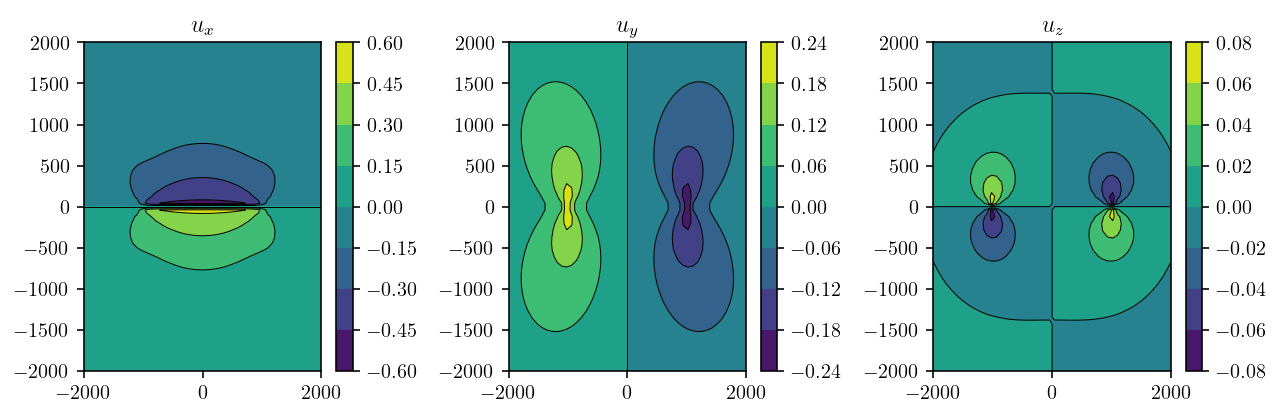

In [10]:
plt.figure(figsize=(9, 3))
for d in range(3):
    plt.subplot(1, 3, 1 + d)
    cntf = plt.contourf(obsx, obsy, okada_disp[:, :, d])
    plt.contour(
        obsx, obsy, okada_disp[:, :, d], colors="k", linestyles="-", linewidths=0.5
    )
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f"$u_{['x','y','z'][d]}$")
plt.tight_layout()
plt.show()

Looking good so far!

So, now the fun part. We need to directly discretize our free surface using TDEs. That means we need a triangular mesh for the free surface. The code below builds a triangular mesh covering an 8000m wide area. Remember our fault is a vertical strike-slip fault 1000m in vertical and horizontal extent and centered at the origin. So, our free surface is going to extend about four fault lengths away from the fault. That's quite different from the Okada half-space free surface which is infinite. However, as we'll see below, the extent of the surface is large enough that the error caused by the approximation to a half-space is very small.

In addition, wondering whether we can represent an infinite half-space misses the point. The half-space itself is an approximation to the surface of the Earth and we can do better using triangles. When we can use arbitrary triangular elements, we can include topography and Earth curvature. If we only selectively refine the mesh near the fault, we can even represent the entire globe using a triangular mesh while still having a small enough problem to be computationally tractable!

In [11]:
surf_L = 4000
n_els_per_dim = 50
mesh_xs = np.linspace(-surf_L, surf_L, n_els_per_dim + 1)
mesh_ys = np.linspace(-surf_L, surf_L, n_els_per_dim + 1)
mesh_xg, mesh_yg = np.meshgrid(mesh_xs, mesh_ys)
surf_pts = np.array([mesh_xg, mesh_yg, 0 * mesh_yg]).reshape((3, -1)).T.copy()
surf_tris = []
nx = ny = n_els_per_dim + 1
idx = lambda i, j: i * ny + j
for i in range(n_els_per_dim):
    for j in range(n_els_per_dim):
        x1, x2 = mesh_xs[i : i + 2]
        y1, y2 = mesh_ys[j : j + 2]
        surf_tris.append([idx(i, j), idx(i + 1, j), idx(i + 1, j + 1)])
        surf_tris.append([idx(i, j), idx(i + 1, j + 1), idx(i, j + 1)])
surf_tris = np.array(surf_tris, dtype=np.int64)

Let's take a quick look at the surface mesh to just check that we did things right.

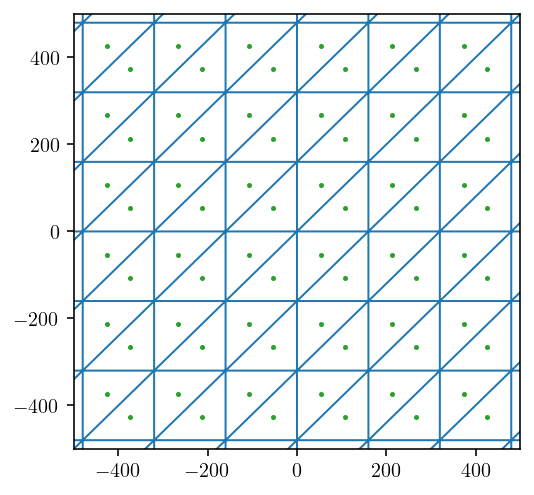

In [12]:
surf_tri_pts = surf_pts[surf_tris]
surf_centroids = np.mean(surf_tri_pts, axis=1)
plt.figure(figsize=(4, 4))
plt.triplot(surf_pts[:, 0], surf_pts[:, 1], surf_tris, linewidth=1.0)
plt.plot(surf_centroids[:, 0], surf_centroids[:, 1], ".", markersize=3)
plt.xlim([-500, 500])
plt.ylim([-500, 500])
plt.show()

### **Building the linear system!**

Now, we're going to construct the linear system we described above. First, for the right hand side, we need to compute the influence of our fault triangules on each surface triangle centroid.

In [13]:
fault_surf_mat = cutde.disp_matrix(surf_centroids, fault_pts[fault_tris], 0.25)
rhs = np.sum(fault_surf_mat[:, :, :, 0], axis=2)

And now, let's construct the left hand side. This will be the influence of surface "slip" on the displacement at the surface.

In [14]:
lhs = cutde.disp_matrix(surf_centroids, surf_pts[surf_tris], 0.25)

Now, there's a bit of complexity. We need to resolve the mismatch in our input (row) and output (column) spaces for the matrix. The output space consists of displacement vectors $(u_x, u_y, u_z)$ in the "Earth-fixed coordinate system" (EFCS). The input space consists of "fictitious slip" (actually displacements!) vectors $(f_{\mathrm{strike-slip}}, f_{\mathrm{dip-slip}}, f_{\mathrm{tensile-slip}})$ in the triangular dislocation coordinate system (TDCS). So, we need to rotate the fictitious slip into the $(x,y,z)$ coordinate space. In a more general setting, we would need to solve for the rotation to convert between these spaces. In our particular problem where the surface is planar, the rotation is simple:

In [15]:
lhs_reordered = np.empty_like(lhs)
lhs_reordered[:, :, :, 0] = lhs[:, :, :, 1]
lhs_reordered[:, :, :, 1] = lhs[:, :, :, 0]
lhs_reordered[:, :, :, 2] = lhs[:, :, :, 2]

We flatten from a four-dimensional array into our two-dimensional matrix.

In [16]:
lhs_reordered = lhs_reordered.reshape((surf_tris.shape[0] * 3, surf_tris.shape[0] * 3))

And finally add the identity matrix term corresponding to $\delta_{ij}$.

In [17]:
lhs_reordered += np.eye(lhs_reordered.shape[0])

And solve!

In [18]:
soln = np.linalg.solve(lhs_reordered, rhs.flatten()).reshape((-1, 3))

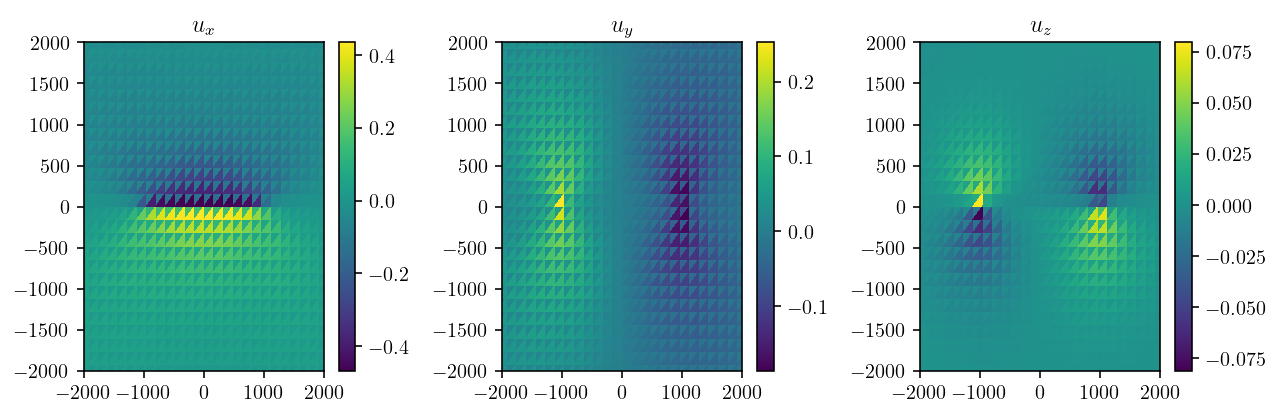

In [19]:
plt.figure(figsize=(9, 3))
for d in range(3):
    plt.subplot(1, 3, 1 + d)
    cntf = plt.tripcolor(surf_pts[:, 0], surf_pts[:, 1], surf_tris, soln[:, d])
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f"$u_{['x','y','z'][d]}$")
plt.tight_layout()
plt.show()

That looks awful. Vaguely in the right direction, but there's an unexpected oscillation layered on top.

### So, do TDEs not work for this problem?!

To understand what's going on, let's back up to the integral equation at hand and think about what we're asking for. Think about the diagonal elements of the matrix where we are asking to compute the value of observation displacement directly on the source TDE. What we're computing is:

\begin{equation}
-\int_{\mathrm{Tri}} T^{*}_{kj}(\mathbf{x},\mathbf{y}) \Delta u_j d\mathbf{y} ~~~~ \mathrm{where} ~~ \mathbf{x} \in \mathrm{Tri}
\end{equation}

But, if we go looking at the expression for $T^*$, there's an ugly looking $1/r^2$ term. If $\mathbf{x}$ is a point on $\mathrm{Tri}$, then that means there's a point in the integral for which $\mathbf{x} = \mathbf{y}$ and $r = 0$. So, the integral is singular! No wonder it's unpleasant to compute a TDE for a point on the surface of the TDE. 

Let's get a concrete sense of what this actually means for computing displacement. In the snippet of code below, we are going to compute the $u_y$ component of displacement due to a triangular dislocation lying on the $x,y$ plane. So, if $z=0$, we are evaluating displacement for a point directly on the triangle.

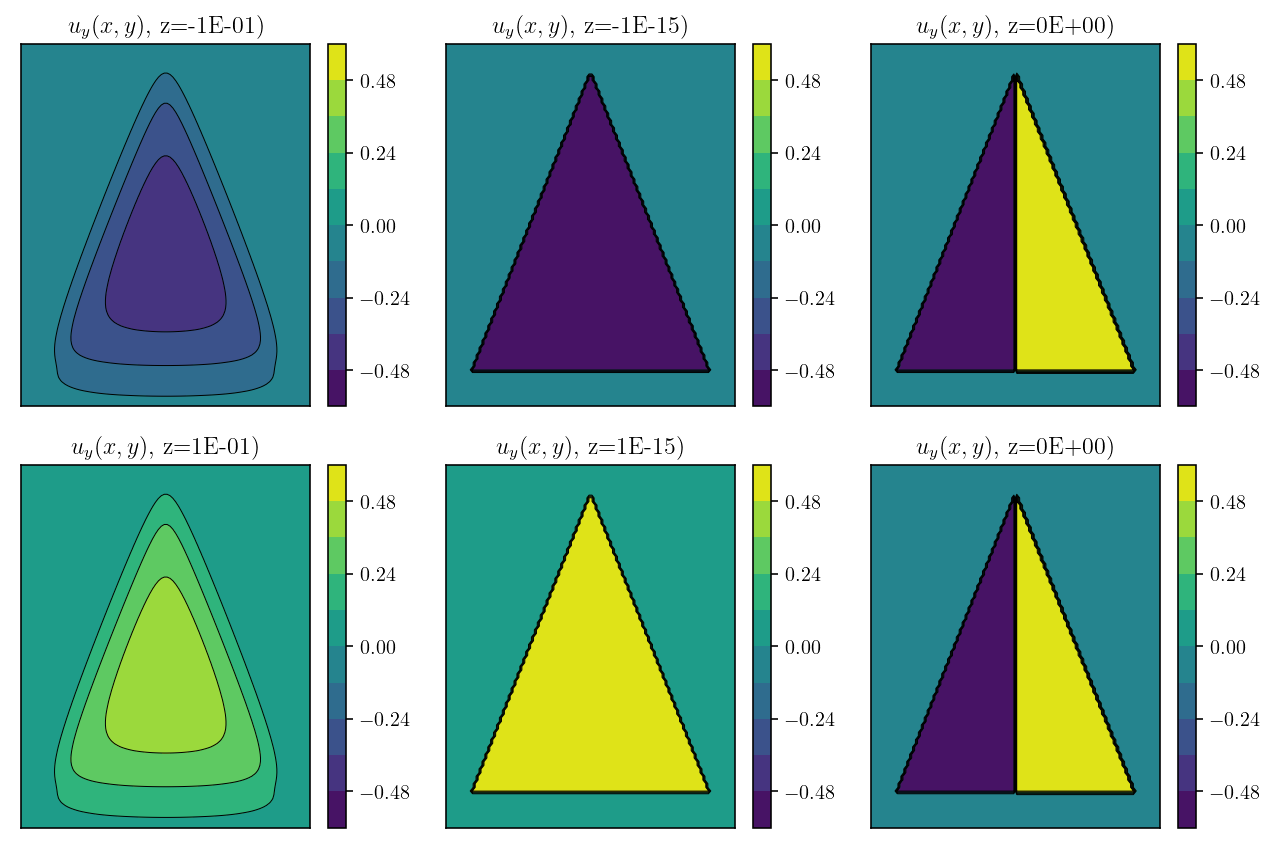

In [20]:
tris = np.array([[[-1, 0, 0], [1, 0, 0], [0, np.sqrt(3), 0]]])
centroid = np.mean(tris, axis=1)

x = np.linspace(-1.2, 1.2, 100)
y = np.linspace(-0.2, 1.9, 100)
z = np.array([-0.1, -1e-15, 0.0, 0.1, 1e-15, 0.0])
obsx, obsy, obsz = np.meshgrid(x, y, z)
pts = np.array([obsx, obsy, obsz]).reshape((3, -1)).T.copy()

disp = cutde.disp_matrix(pts, tris, 0.25)[:, :, 0, 0].reshape((*obsx.shape, 3))


def plotter(idx, d):
    levels = np.linspace(-0.6, 0.6, 11)
    cntf = plt.contourf(
        obsx[:, :, idx], obsy[:, :, idx], disp[:, :, idx, d], levels=levels
    )
    plt.contour(
        obsx[:, :, idx],
        obsy[:, :, idx],
        disp[:, :, idx, d],
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
    )
    plt.colorbar(cntf)
    plt.title(f"$u_{['x','y','z'][d]}$")
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)


plt.figure(figsize=(9, 6))
for i in range(z.shape[0]):
    plt.subplot(2, 3, 1 + i)
    plotter(i, 1)
    plt.title(f"$u_y(x, y)$, z={obsz[0,0,i]:.0E})")
plt.tight_layout()
plt.show()

As seen from comparing the figures in the second column above, the value of $u_y$ has a jump in value of 1.0m when crossing from $z=-(10^{-15})$ to $z=10^{-15}$. This jump is equal to the slip, as expected. In essence, we are seeing the $\lim_{z \to 0^{-}} u_y = -0.5$ and $\lim_{z \to 0^{+}} u_y = 0.5$.

However, the particularly interesting thing here is that the value of $u_y$ as computed by the Nikhoo and Walter 2015 solution is equal to the negative limit for $x < 0$ and equal to the positive limit for $x > 0$. This is exactly what is resulting in the oscillations we see in the final topographic solution we computed above. It's not surprising that the solution is indecisive like this when it comes to what value to assign to $u_y(z = 0)$. 

The solution to this issue is to back up and reconsider the "collocation step". This was the step in our derivation where we chose the element centroids as the locations where we impose the integral equation by choosing those centroids as our observation points. That step is where we introduced this singularity/indeterminacy. So, the goal is to modify that step slightly to avoid the problem!

Instead of choosing the centroids, let's choose a point, in our geometry, slightly below the centroid, a few centimeters into the Earth. In a more general geometry, we could just say move $\varepsilon$ along the element normal vector. Since this point isn't on the source triangule, but instead slightly below it, there is no singularity. Now, let's take the limit as $\varepsilon \to 0$. This is a much more mathematically robust way of defining our integral equation and immediately transfers to the discretization. The general idea is inspired by the quadrature by expansion technique {cite:p}`Klckner2013` and other "limit-to-the-boundary" boundary element methods like approach from {cite:t}`Sutradhar2008`.

A complication here is that, in a real-world setting, we may have dimension on the order of $10^6$ meters (1,000 kilometers). As a result, in single precision arithmetic, adding a tiny offset to the current triangle centroid may result in a round-off error such that the offset is actually zero. In this situation, it is better to directly compute the limit via numerical limit techniques from multiple points farther from the boundary. For example, below, we could compute the TDE matrix for two different values of $\varepsilon$ - `[0.002, 0.001]`. Then, we use a simple one step [Richardson extrapolation](https://en.wikipedia.org/wiki/Richardson_extrapolation) to compute a more accurate estimate of the limit. Because the error is already quite small by choosing points very close to the boundary, this crude limit is actually extremely accurate! A convergence check of this numerical limit would be straightforward but I'm going to leave it out here.

In [21]:
eps_mats = []
for offset in [0.002, 0.001]:
    offset_centers = np.mean(surf_tri_pts, axis=1)
    # Offset the observation coordinates by a small amount.
    offset_centers[:, 2] -= offset
    eps_mats.append(cutde.disp_matrix(offset_centers, surf_pts[surf_tris], 0.25))

# A simple one step "richardson extrapolation". This seems to reduce the "offset error" to basically zero.
lhs = 2 * eps_mats[1] - eps_mats[0]

Finish solving the problem exactly as before but with a more accurate matrix.

In [22]:
lhs_reordered = np.empty_like(lhs)
lhs_reordered[:, :, :, 0] = lhs[:, :, :, 1]
lhs_reordered[:, :, :, 1] = lhs[:, :, :, 0]
lhs_reordered[:, :, :, 2] = lhs[:, :, :, 2]

lhs_reordered = lhs_reordered.reshape((surf_tris.shape[0] * 3, surf_tris.shape[0] * 3))

lhs_reordered += np.eye(lhs_reordered.shape[0])

soln = np.linalg.solve(lhs_reordered, rhs.flatten()).reshape((-1, 3))

And, let's calculate the Okada solution at the same elements centroid points so that we can compare!

In [23]:
okada_lhs = np.empty_like((n_els_per_dim, 3, n_els_per_dim, 3))
okada_soln = np.empty_like(soln)
okada_pts = np.mean(surf_tri_pts, axis=1)
for i in range(okada_pts.shape[0]):
    success, okada_soln[i], _ = okada_wrapper.dc3dwrapper(
        alpha,
        okada_pts[i].tolist(),
        fault_D + fault_H / 2.0,
        90,
        [-fault_L, fault_L],
        [-fault_H / 2.0, fault_H / 2.0],
        [1.0, 0.0, 0.0],
    )
    assert success == 0

### Okada vs Fullspace TDEs

This is a comparison between Okada and a solution derived from fullspace TDEs. The first row is Okada, the second is the solution from TDEs. The third is the error. The error is on the order of 1% in the $u_x$ and $u_y$ components and 2.5% in $u_z$. The error is focused right around the fault tips. To reduce the error further, we would need a higher resolution discretization in those areas. That's entirely feasible!

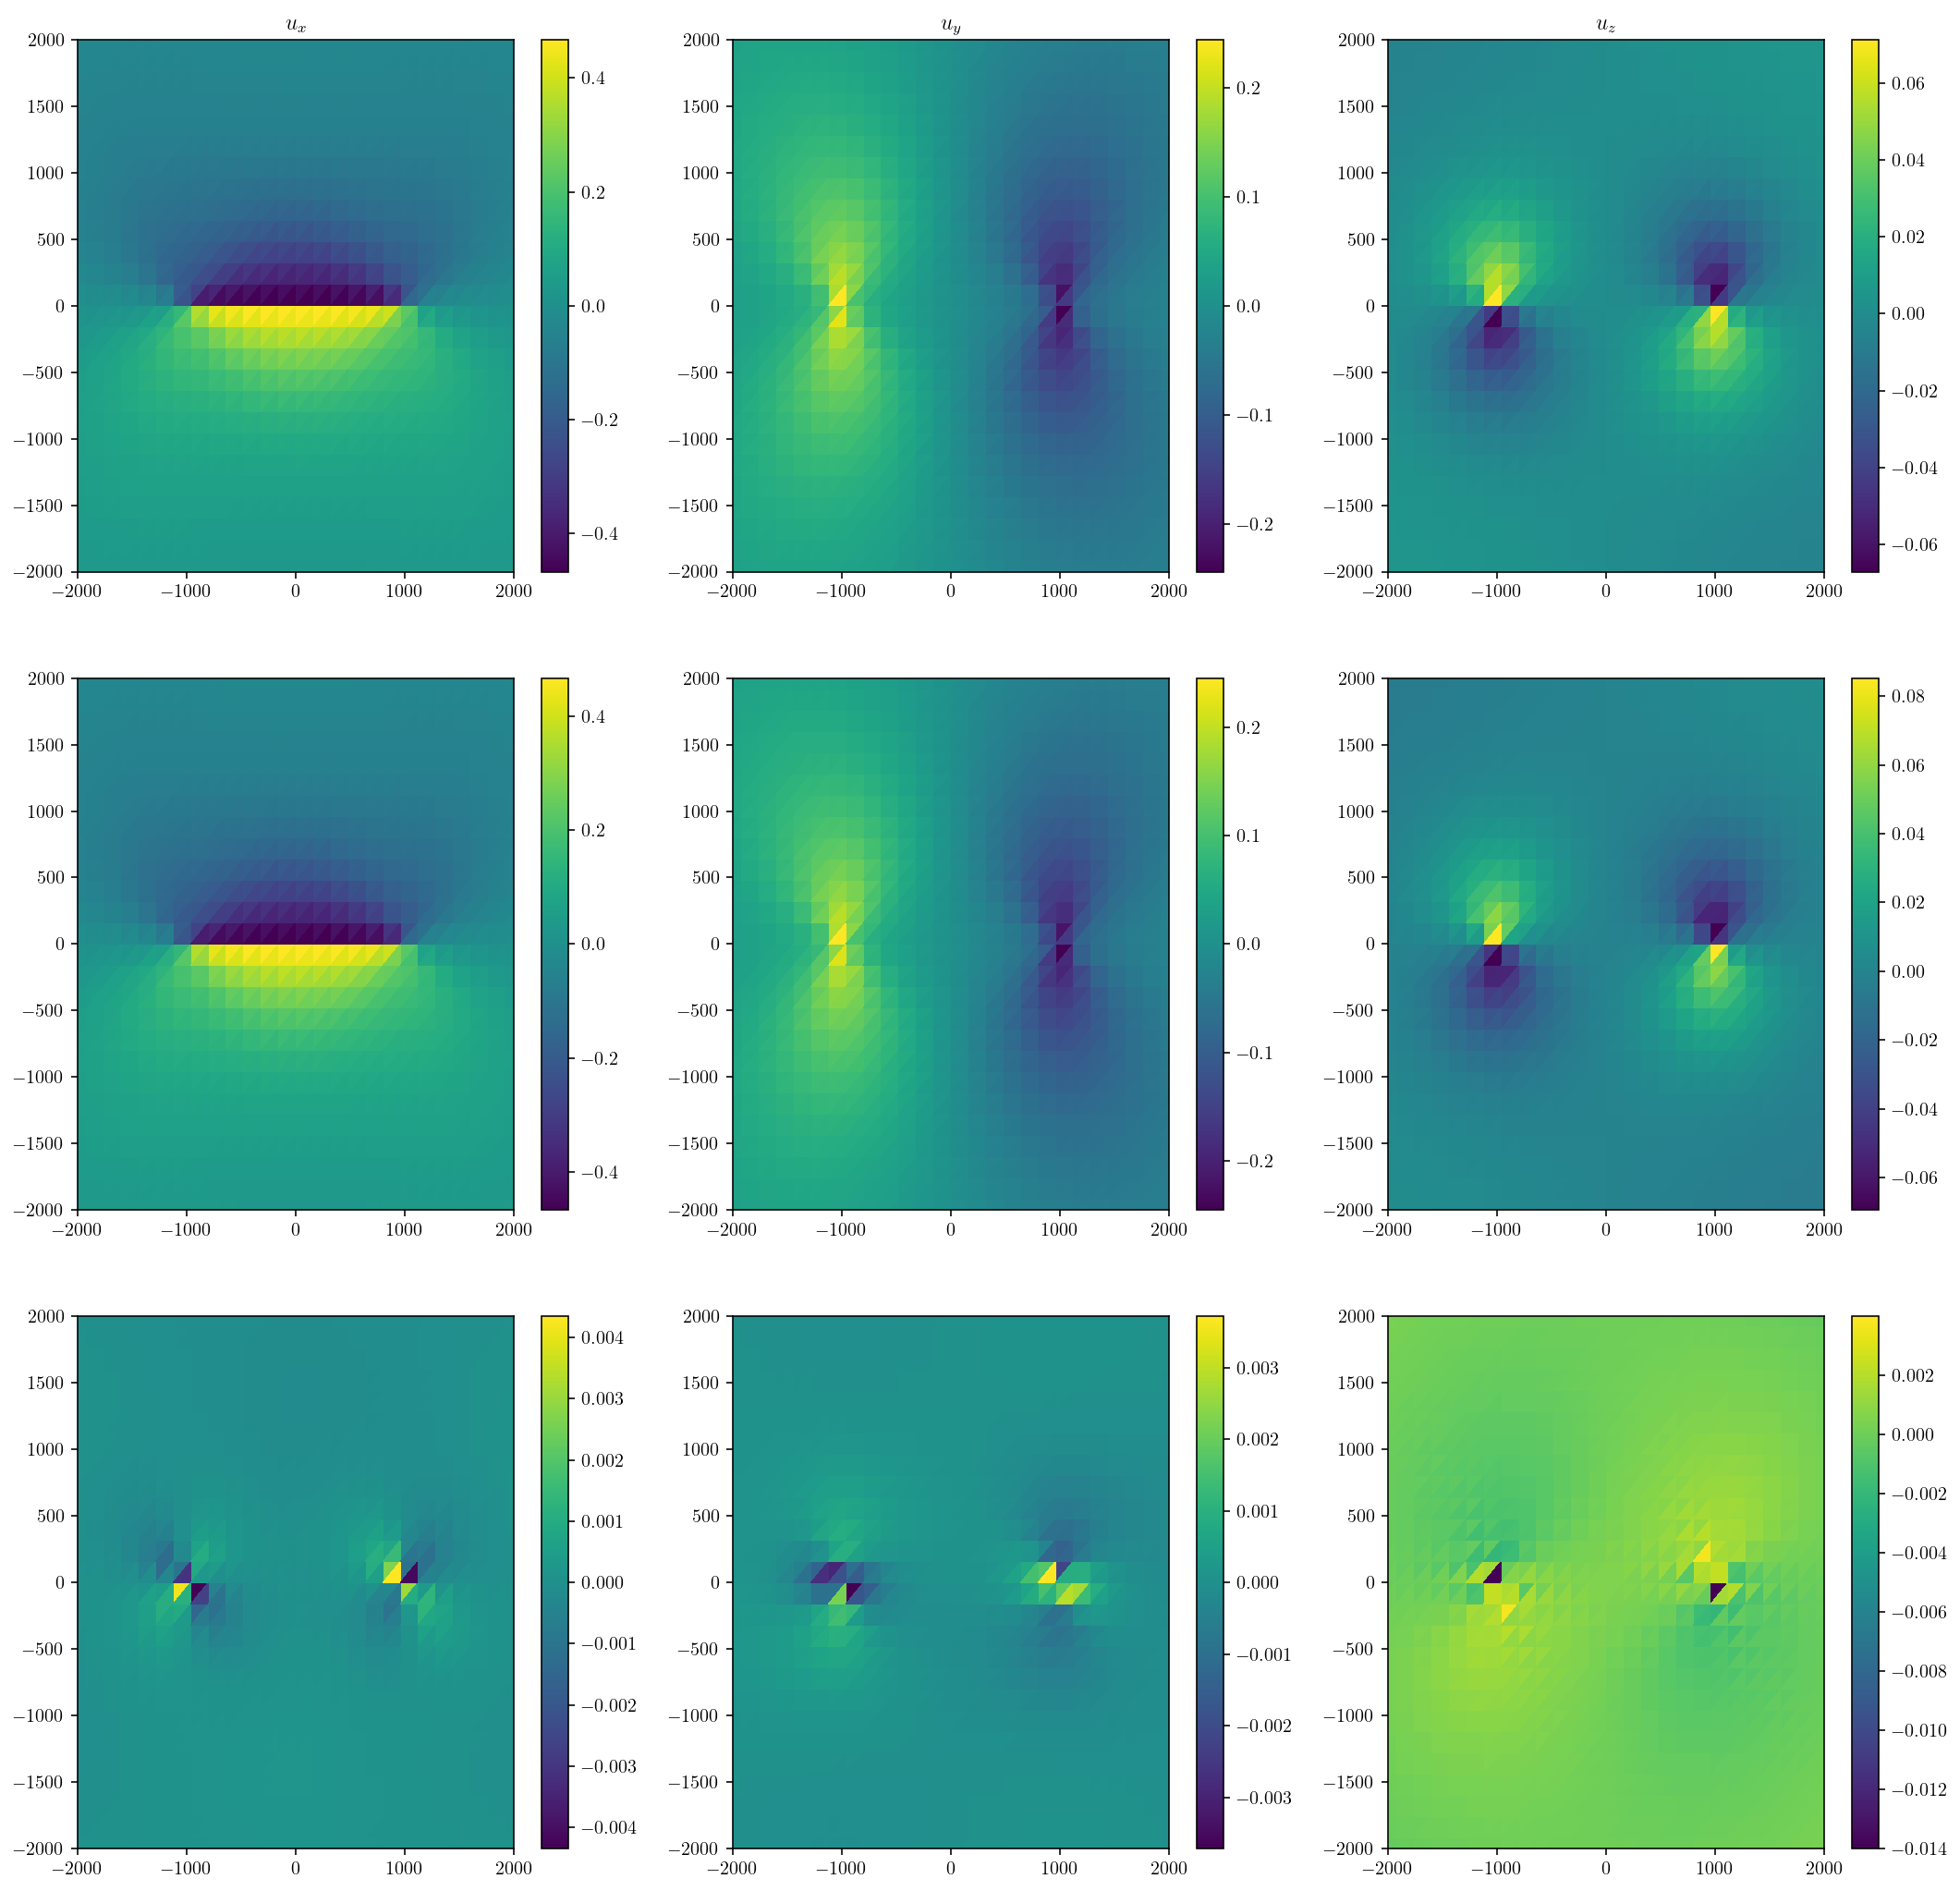

In [24]:
plt.figure(figsize=(18, 18))

dimnames = ["x", "y", "z"]
for d in range(3):
    plt.subplot(3, 3, d + 1)
    cntf = plt.tripcolor(surf_pts[:, 0], surf_pts[:, 1], surf_tris, okada_soln[:, d])
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f"$u_{dimnames[d]}$")

for d in range(3):
    plt.subplot(3, 3, d + 4)
    cntf = plt.tripcolor(surf_pts[:, 0], surf_pts[:, 1], surf_tris, soln[:, d])
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

for d in range(3):
    plt.subplot(3, 3, d + 7)
    cntf = plt.tripcolor(
        surf_pts[:, 0], surf_pts[:, 1], surf_tris, okada_soln[:, d] - soln[:, d]
    )
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

plt.show()

## South American subduction model

So, we've demonstrated an effective method for modeling a fault below a triangulated free surface. Let's use this technique for something slightly more interesting. A bizarre freak earthquake on the entire South America subduction zone beneath a topographic free surface with Earth curvature. 

I've built the mesh for this already, so I'll just load it up and plot it.

In [25]:
import cutde
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'
(surf_pts_lonlat, surf_tris), (fault_pts_lonlat, fault_tris) = np.load(
    "sa_mesh4_1804.npy", allow_pickle=True
)

First, a lat-lon plot:

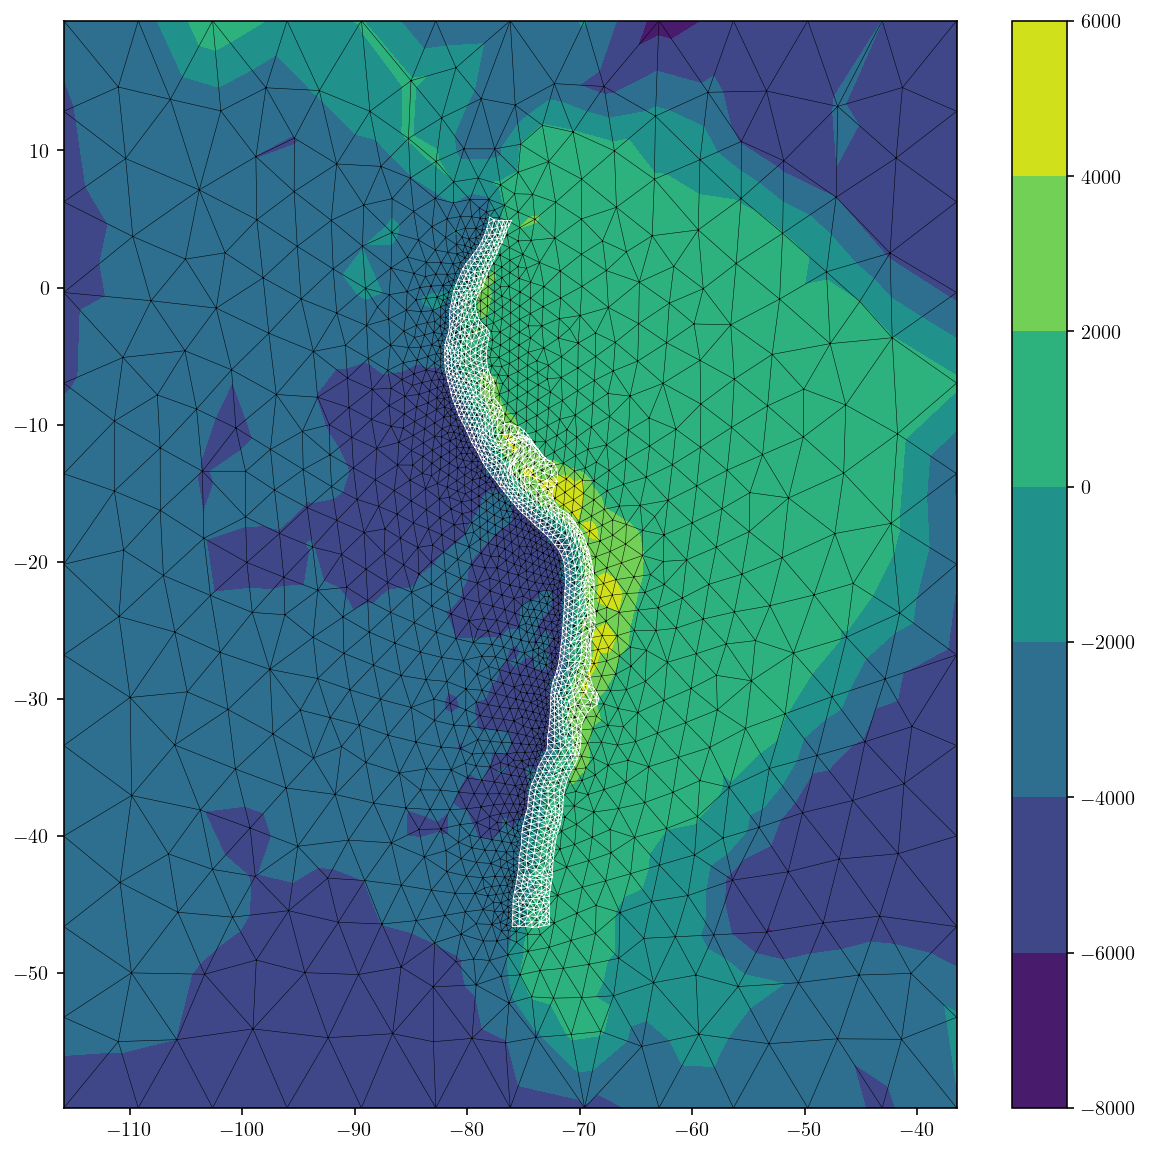

In [26]:
plt.figure(figsize=(10, 10))
cntf = plt.tricontourf(
    surf_pts_lonlat[:, 0], surf_pts_lonlat[:, 1], surf_tris, surf_pts_lonlat[:, 2]
)
plt.triplot(
    surf_pts_lonlat[:, 0], surf_pts_lonlat[:, 1], surf_tris, "k-", linewidth=0.25
)
plt.triplot(
    fault_pts_lonlat[:, 0], fault_pts_lonlat[:, 1], fault_tris, "w-", linewidth=0.4
)
plt.colorbar()
plt.show()

And then project it into $(x, y, z)$ coordinates centered at the center of the Earth. `collect_dem` is a small module I've written for collecting digital elevation data from a publicly AWS.

In [27]:
from pyproj import Transformer

transformer = Transformer.from_crs(
    "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs",
    "+proj=geocent +datum=WGS84 +units=m +no_defs",
)
surf_pts_xyz = np.array(
    transformer.transform(
        surf_pts_lonlat[:, 0], surf_pts_lonlat[:, 1], surf_pts_lonlat[:, 2]
    )
).T.copy()
fault_pts_xyz = np.array(
    transformer.transform(
        fault_pts_lonlat[:, 0], fault_pts_lonlat[:, 1], fault_pts_lonlat[:, 2]
    )
).T.copy()

For reference we have a little less than four thousand surface triangles:

In [28]:
surf_tris.shape[0]

3812

Let's make a fun 3D interactive figure.

In [29]:
import k3d

plot = k3d.plot()
sm = k3d.mesh(surf_pts_xyz, surf_tris, attribute=surf_pts_lonlat[:, 2], opacity=0.75)
sm2 = k3d.mesh(
    surf_pts_xyz,
    surf_tris,
    attribute=surf_pts_lonlat[:, 2],
    wireframe=True,
    opacity=0.15,
)
fm = k3d.mesh(fault_pts_xyz, fault_tris, color=0x0000FF, wireframe=True)
plot += sm
plot += sm2
plot += fm
plot

/home/tbent/.miniconda3/envs/bie_book/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(
/home/tbent/.miniconda3/envs/bie_book/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(
/home/tbent/.miniconda3/envs/bie_book/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "uint16" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[2, -3, 0.2, 0.0, 0…

In [30]:
plot.camera = [
    3758089.565316397,
    -9275705.951062605,
    -3929514.939762978,
    927453.125,
    -3565043.375,
    -1350349.625,
    0.16444049179218606,
    -0.39365328742375527,
    0.904431541886733,
]

### Rotations

Next, the hard part. We need to deal with rotating vectors into the various coordinate systems we have:
* The Earth-fixed geocentric $(x,y,z)$ coordinate system (`xyz`) that our model is built in. This will be the primary calculation coordinate system
* The WGS84 lat-lon coordinate system (`lonlat`) that allows talking about normal cardinal directions like "east" or "north". This will be a nice coordinate system for reporting intuitive outputs and making figures. 
* The triangular dislocation coordinate system (`tdcs`) constructed from the `xyz` system where vectors are described in terms of `(strike-slip, dip-slip, tensile-slip)`. 

There will be an additional complication. When the `tdcs` coordinate system is built from `xyz`, the strike and dip vectors will not be pointing in the intuitive direction because the concept of a flat strike vector doesn't map easily into the `xyz` coordinate system. So, we will build a third `tdcs2` coordinate system from the `lonlat` coordinate system for use whenever we want to discuss the concepts of strike and dip in a coherent way. The `tdcs` coordinate system built from `xyz` will only be used for providing inputs in the format expected by the TDE solutions in `cutde`. This might be a bit confusing, but hopefully the code will help clarify.

To build the various rotation matrices, we will use two functions from `cutde`:
* `compute_project_transforms(surf_lonlat_centers, transformer)` uses the `pyproj` transformer we specified before to compute the `lonlat` to `xyz` rotation matrices at each triangle centroid.
* `compute_efcs_to_tdcs_rotations(fault_pts[fault_tris])` computes the `(strike, dip, tensile)` rotation matrix for each triangle.

In [31]:
surf_centers_lonlat = np.mean(surf_pts_lonlat[surf_tris], axis=1)
surf_lonlat_to_xyz_T = cutde.compute_projection_transforms(
    surf_centers_lonlat, transformer
)

surf_tri_pts_xyz = surf_pts_xyz[surf_tris]
surf_xyz_to_tdcs_R = cutde.compute_efcs_to_tdcs_rotations(surf_tri_pts_xyz)

surf_tri_pts_lonlat = surf_pts_lonlat[surf_tris]
surf_tdcs2_to_lonlat_R = cutde.compute_efcs_to_tdcs_rotations(surf_tri_pts_lonlat)

In [32]:
fault_centers_lonlat = np.mean(fault_pts_lonlat[fault_tris], axis=1)
fault_lonlat_to_xyz_T = cutde.compute_projection_transforms(
    fault_centers_lonlat, transformer
)

fault_tri_pts_xyz = fault_pts_xyz[fault_tris]
fault_xyz_to_tdcs_R = cutde.compute_efcs_to_tdcs_rotations(fault_tri_pts_xyz)

fault_tri_pts_lonlat = fault_pts_lonlat[fault_tris]
fault_tdcs2_to_lonlat_R = cutde.compute_efcs_to_tdcs_rotations(fault_tri_pts_lonlat)

In [33]:
strike_lonlat = fault_tdcs2_to_lonlat_R[:, 0, :]
dip_lonlat = fault_tdcs2_to_lonlat_R[:, 1, :]

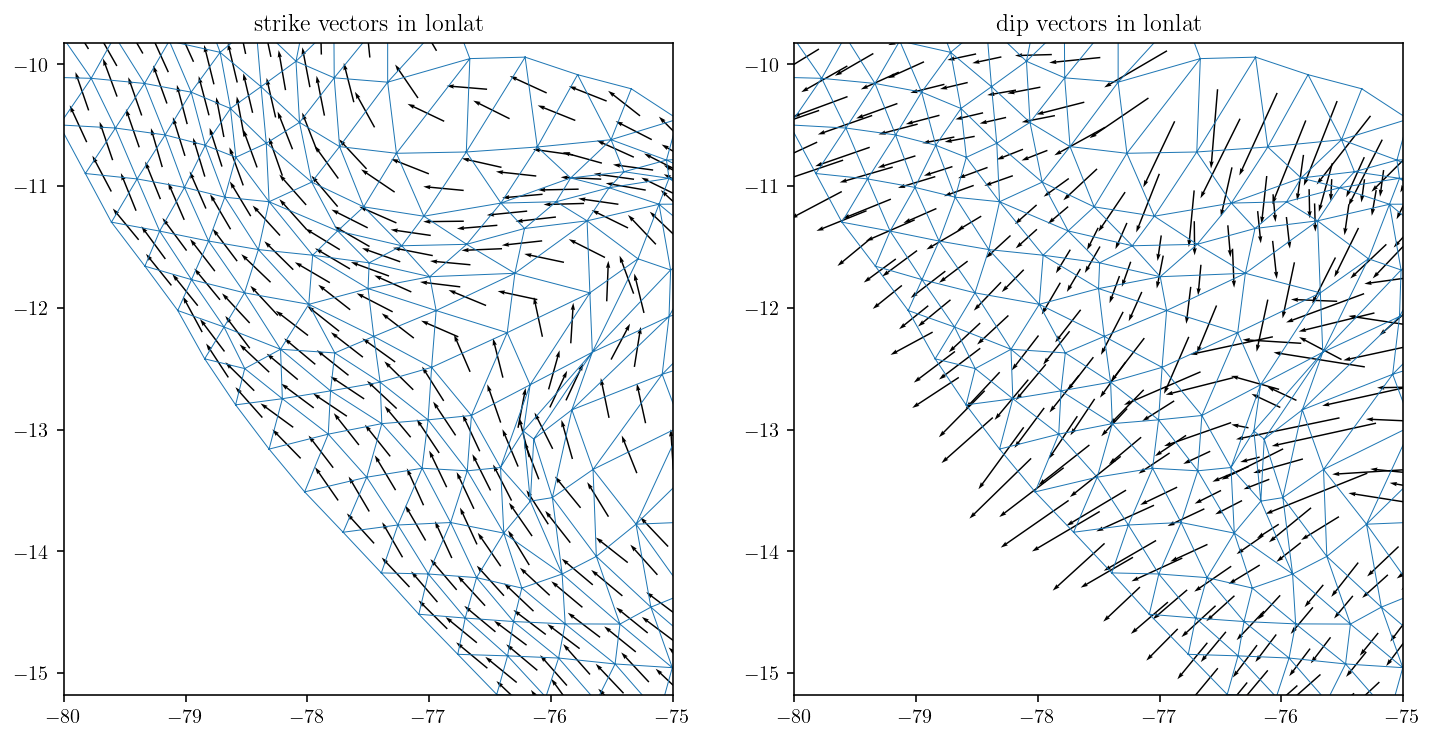

In [34]:
plt.figure(figsize=(12, 6))
for d in range(2):
    plt.subplot(1, 2, 1 + d)
    plt.triplot(
        fault_pts_lonlat[:, 0], fault_pts_lonlat[:, 1], fault_tris, linewidth=0.5
    )
    v = [strike_lonlat, dip_lonlat][d]
    plt.quiver(
        fault_centers_lonlat[:, 0],
        fault_centers_lonlat[:, 1],
        v[:, 0],
        v[:, 1],
        scale=[15, 0.0005][d],
    )
    plt.axis("equal")
    plt.xlim([-80, -75])
    plt.ylim([-15, -10])
    plt.title(["strike vectors in lonlat", "dip vectors in lonlat"][d])
plt.show()

Transform these strike and dip vectors into the `xyz` coordinate system. And then normalize for unit vectors.

In [35]:
strike_xyz = np.sum(fault_lonlat_to_xyz_T * strike_lonlat[:, None, :], axis=2)
strike_xyz /= np.linalg.norm(strike_xyz, axis=1)[:, None]
dip_xyz = np.sum(fault_lonlat_to_xyz_T * dip_lonlat[:, None, :], axis=2)
dip_xyz /= np.linalg.norm(dip_xyz, axis=1)[:, None]

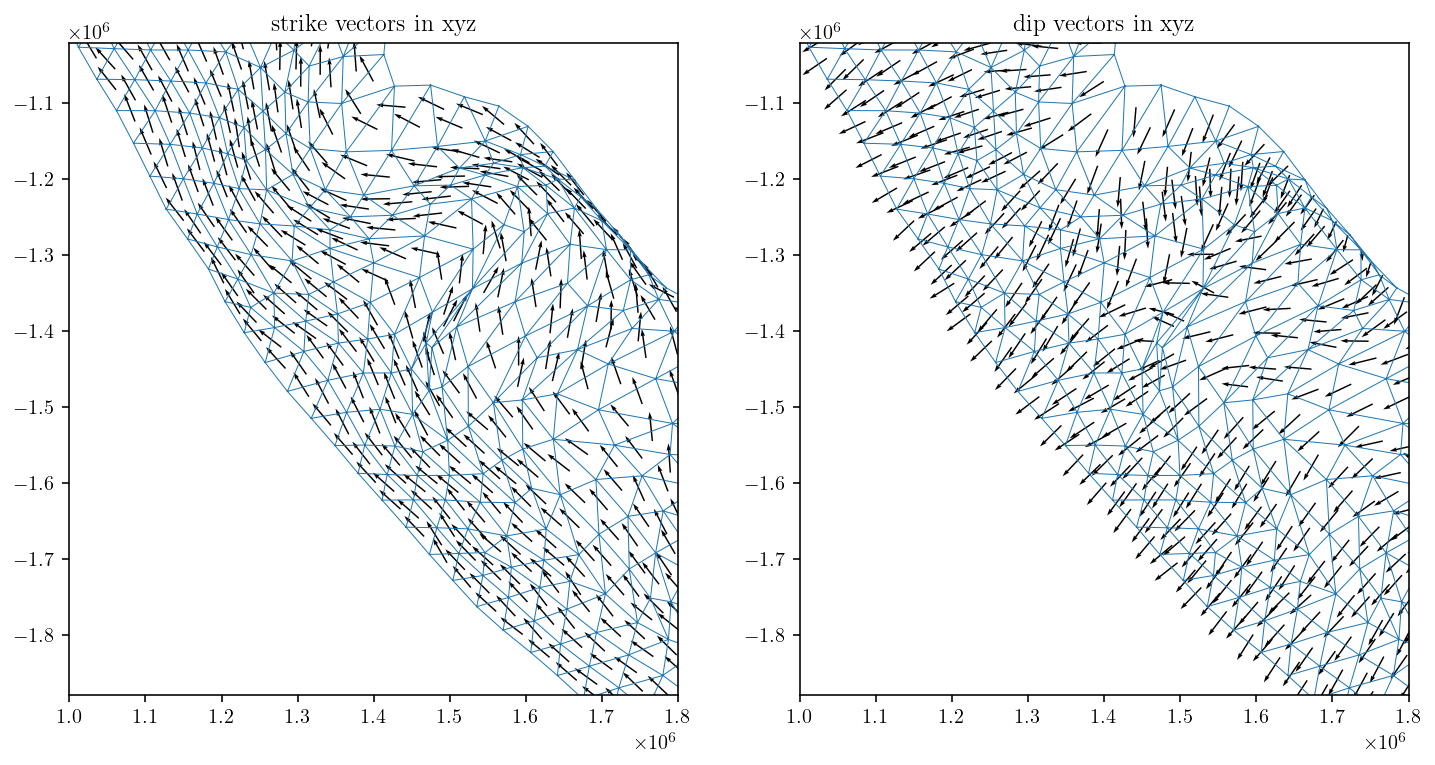

In [36]:
fault_centers_xyz = np.mean(fault_pts_xyz[fault_tris], axis=1)
plt.figure(figsize=(12, 6))
for d in range(2):
    plt.subplot(1, 2, 1 + d)
    plt.triplot(fault_pts_xyz[:, 0], fault_pts_xyz[:, 2], fault_tris, linewidth=0.5)
    v = [strike_xyz, dip_xyz][d]
    plt.quiver(
        fault_centers_xyz[:, 0], fault_centers_xyz[:, 2], v[:, 0], v[:, 2], scale=20
    )
    plt.axis("equal")
    plt.xlim([1.0e6, 1.8e6])
    plt.ylim([-1.65e6, -1.25e6])
    plt.title(["strike vectors in xyz", "dip vectors in xyz"][d])
plt.show()

Looking good!

### Solving

Now, we'll set up the linear system and solve for surface displacement due to a one meter dip slip event on the entire subduction zone.

The first section calculates the self-interaction matrix for the free surface. It's essentially identical to the Okada replication case except that we:
1. Use `surf_xyz_to_tdcs_R` to rotate our `fictitious_slip` vectors into the TDE coordinate system.
2. The offset is in the direction of the normal vector, `Vnormal`. Before, we simply assumed that the normal was $(0,0,1)$ because the surface was planar.
3. The offsets are chosen to be `[2.0, 1.0]` instead of `[0.02, 0.01]`. This is simply because the scale of the problem is much larger. As a percentage of the triangle size, this is about the same offset. In a more robust implementation, we could choose the offset as a function of the size of the triangle. The offset distance is a somewhat flexible parameter, but it's important to avoid the offset point being too far away for good accuracy or too close such that we hit floating point round-off issues.

In [37]:
ft = np.float32
# The normal vectors for each triangle are the third rows of the XYZ->TDCS rotation matrices.
Vnormal = surf_xyz_to_tdcs_R[:, 2, :]
surf_centers_xyz = np.mean(surf_tri_pts_xyz, axis=1)
surf_tri_pts_xyz_conv = surf_tri_pts_xyz.astype(ft)

# The rotation matrix from TDCS to XYZ is the transpose of XYZ to TDCS.
# The inverse of a rotation matrix is its transpose.
surf_tdcs_to_xyz_R = np.transpose(surf_xyz_to_tdcs_R, (0, 2, 1)).astype(ft)

eps_mats = []
for offset in [2.0, 1.0]:
    # offset by a multiple of the normal vector.
    # the offset is negative because we want to offset into the interior of the Earth.
    offset_centers = (surf_centers_xyz - offset * Vnormal).astype(ft)
    offset_disp_mat = cutde.disp_matrix(offset_centers, surf_tri_pts_xyz_conv, 0.25)

    # rotate into XYZ coordinates for the source slip.
    rot_mat = np.sum(
        offset_disp_mat[:, :, :, None, :] * surf_tdcs_to_xyz_R[None, None, :, :, :],
        axis=4,
    )

    eps_mats.append(rot_mat)

# extrapolate to the boundary.
lhs = 2 * eps_mats[1] - eps_mats[0]

For the slip vector, we use `dip_xyz` which is the unit dip vector transformed into the `xyz` coordinate system.

In [38]:
slip = np.sum(fault_xyz_to_tdcs_R * dip_xyz[:, None, :], axis=2)
fault_surf_mat = cutde.disp_matrix(
    surf_centers_xyz.astype(ft), fault_pts_xyz[fault_tris].astype(ft), 0.25
)
rhs = np.sum(np.sum(fault_surf_mat * slip[None, None, :, :], axis=3), axis=2)

In [39]:
lhs = lhs.reshape((surf_tris.shape[0] * 3, surf_tris.shape[0] * 3))
np.fill_diagonal(lhs, np.diag(lhs) + 1.0)

Solve the linear system! This isn't an unreasonable size to solve on a normal laptop. The matrix itself should require about 0.5Gb of memory.

In [40]:
print(f"matrix shape {lhs.shape}, memory use: {lhs.nbytes / 1e6} Mb")

matrix shape (11436, 11436), memory use: 523.128384 Mb


In [41]:
%%time
soln = np.linalg.solve(lhs, rhs.flatten()).reshape((-1, 3))

CPU times: user 39.4 s, sys: 1.35 s, total: 40.8 s
Wall time: 7.49 s


Note that the displacements are in the $(x,y,z)$ geocentric coordinate system. So, $u_x$ is not exactly an east-west component. Similarly, $u_y$ and $u_z$ don't map to standard compass directions or up/down. To map into standard compass directions, we need to do another rotation step back into the `lonlat` coordinate system. This will be the inverse projection from what did before with `pyproj`. I've just flipped the input and output projection specification strings.

In [42]:
inverse_transformer = Transformer.from_crs(
    "+proj=geocent +datum=WGS84 +units=m +no_defs",
    "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs",
)
surf_xyz_to_lonlat_T = cutde.compute_projection_transforms(
    surf_centers_xyz, inverse_transformer
)

We'll also scale the columns of the transformation matrices to make this into a true rotation matrix. This is nice because the output will then be in terms of meters in the `(east, north, up)` coordinate system.

In [43]:
surf_xyz_to_lonlat_T /= np.linalg.norm(surf_xyz_to_lonlat_T, axis=2)[:, :, None]

soln_lonlat = np.sum(surf_xyz_to_lonlat_T * soln[:, None, :], axis=2)

Let's plot the solution! It looks pretty much like I'd expect with motion towards the fault trace and uplift near the fault trace. Obviously this isn't a useful scientific result, but I hope it's been a useful demonstration of how to use basic fullspace TDEs to solve a real-world dislocation, topography and Earth curvature problem.

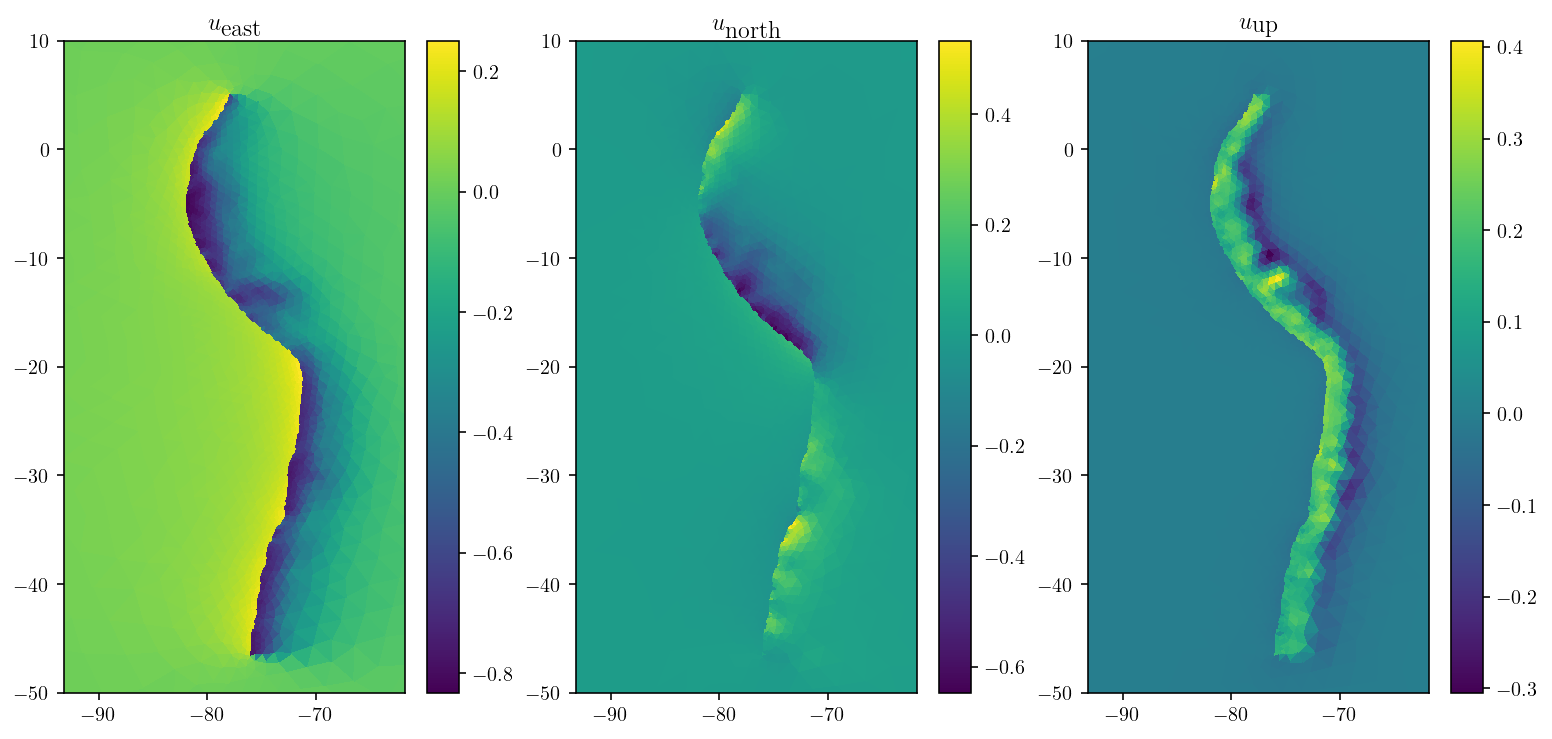

In [44]:
plt.figure(figsize=(13, 6))
for d in range(3):
    plt.subplot(1, 3, 1 + d)
    cntf = plt.tripcolor(
        surf_pts_lonlat[:, 0], surf_pts_lonlat[:, 1], surf_tris, soln_lonlat[:, d]
    )
    plt.colorbar(cntf)
    plt.axis("equal")
    plt.xlim([-85, -70])
    plt.ylim([-50, 10])
    plt.title(
        ["$u_{\\textrm{east}}$", "$u_{\\textrm{north}}$", "$u_{\\textrm{up}}$"][d]
    )
plt.show()